In [12]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import time
import torchvision.models as models

In [28]:
datasetPath = '/kaggle/input/fer2013/FER2013/test/'
modelPath = '/kaggle/input/sample2/TL_resnet18_FER2013.pth'

In [29]:
class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [30]:
def test_model(model, test_loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(datasetPath) for f in filenames if f.endswith(('.jpg', '.png'))]
print('test_images:',len(test_images))

test_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((224, 224))
        ])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

test_data = dataset(datasetPath, test_transforms, device)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

pretrainedFlag= False

if 'TL' in modelPath:
    pretrainedFlag = True
    if 'resnet18' in modelPath:
        model = models.resnet18(pretrained=pretrainedFlag)
        model.fc = torch.nn.Linear(model.fc.in_features, len(test_data.class_names))
    elif 'mobilenet_v2' in modelPath:
        model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=pretrainedFlag)
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Linear(num_ftrs, len(test_data.class_names))
        model.fc = nn.Linear(num_ftrs, len(test_data.class_names))
    elif 'shufflenet_v2_x1_0' in modelPath:
        model = torch.hub.load('pytorch/vision:v0.9.0', 'shufflenet_v2_x1_0', pretrained=pretrainedFlag)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(test_data.class_names))

state_dict = torch.load(modelPath)
state_dict = {k: v.to(device) for k, v in state_dict.items()}
model.load_state_dict(state_dict, strict=False)
model = model.to(device)


test_images: 1020


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

Test Results:
Test Accuracy: 0.8176

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       340
           1       0.75      0.86      0.80       340
           2       0.86      0.82      0.84       340

    accuracy                           0.82      1020
   macro avg       0.82      0.82      0.82      1020
weighted avg       0.82      0.82      0.82      1020



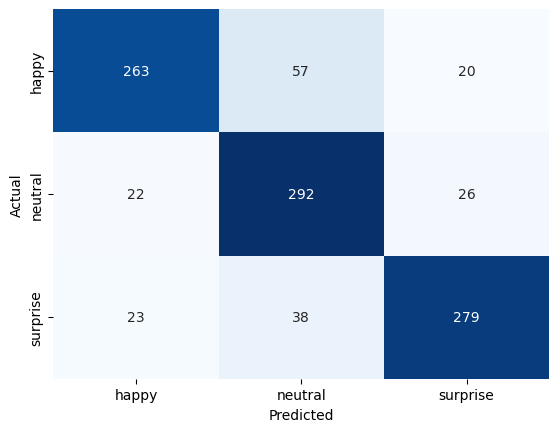

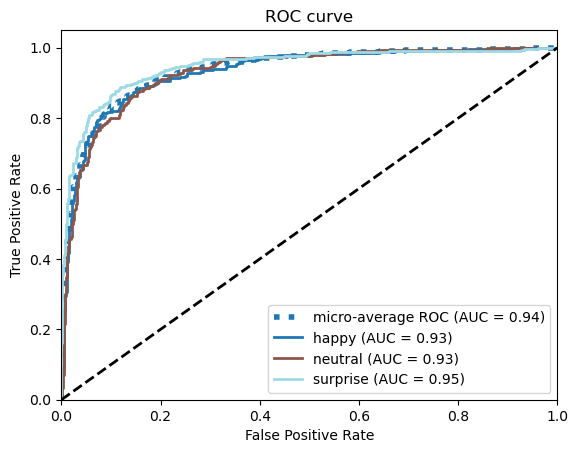

In [32]:
test_model(model, test_loader, device)